In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import Counter
# svg output in plots
import numpy as np
import tqdm as tqdm
from itertools import chain
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Parameters

In [9]:
# Load data
df = pd.read_pickle(r"../Dataset/dataframe.pkl")
df = df[df["Time"] > 1950]

df_i = df.explode("Simplices").reset_index()
all_authors = df_i["Simplices"].unique()
N_a = len(all_authors)
print("Number of authors:", N_a)

Number of authors: 1242372


In [10]:
### Initial condition age distribution

df_all = pd.read_pickle(r"../Dataset/dataframe.pkl")
df_all = df_all.explode("Simplices").reset_index()
all_ini = df_all.groupby("Simplices").min("Time").reset_index()

all_ini["Age"] = 1950 -  all_ini["Time"]

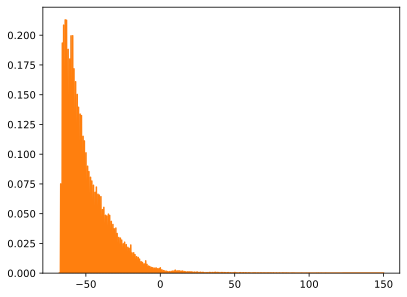

In [21]:
x = plt.hist(all_ini["Age"], bins=1000, density=True, cumulative=False);

plt.plot(x[1][1:], x[0], label="Initial condition")

### Academic age distribution

x_life = x[1][1:] + 40     #np.linspace(0,80,1001)
f_life = x[0]
#plt.plot(x_life,f_life,color="black",linestyle="",marker=".",linewidth=4)

all_ages = np.random.choice(x_life, size=len(all_authors), p=f_life/np.sum(f_life))

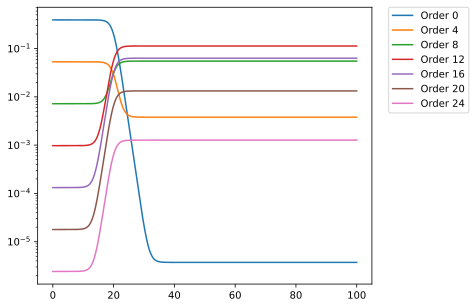

In [43]:
def dist_order(order,age,N):
    alpha = 0.5*(1 + np.tanh(0.5*(age-20)))
    s = 0.5
    Z = np.sum([np.exp(-0.5*o) for o in range(N)])
    e = np.exp(-0.5*order)/Z
    lam = N/2
    Pois = np.exp(-lam)*lam**(order)/np.math.factorial(order)
    return (1-alpha)*e + alpha*Pois

fig, ax = plt.subplots(figsize=(6,5))
v = np.linspace(0,100, 1001)
for order in range(0, 25, 4):
    plt.plot(v, dist_order(order, v, 25), label="Order {}".format(order))
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout
plt.yscale("log")

In [59]:
t0 = 1950
tf = 1960

# Not all authors at the reservoir
N_a = 1000
authors = np.array(all_authors[0:N_a])
ages = np.array(all_ages[0:N_a])

# Parameters
N = 25 # Maximum number of orders
r = (np.log(10**5 - 10**3))/60 # simplices x year
N_simplices = 20 # Number of simplices at t0

# Memory matrix
M = np.ones((N_a,N_a))

# If the ages are < 0 or > age_max, we set M = 0
age_max = 80
for i in range(N_a):
    M[i,ages > age_max] = 0
    M[ages > age_max,i] = 0
    M[i,i] = 0

ti = t0

simplices = []
time = []

def p(x, age_max=age_max):
    if x > age_max:
        return 0
    elif x <= 0:
        return 0
    else:
        return 1/(1+x)

def dist_order(order,age,N):
    alpha = 0.5*(1 + np.tanh(0.5*(age-20)))
    s = 0.4
    Z = np.sum([np.exp(-s*o) for o in range(N)])
    e = np.exp(-s*order)/Z
    lam = (N)/3
    Pois = np.exp(-lam)*lam**(order)/np.math.factorial(order)
    return (1-alpha)*e + alpha*Pois

w_t = 0
print("Model starts running")
while ti < tf:
    # Compute total rate:
    W = (r+1)*N_simplices
    
    # Compute next event time
    At = - np.log(np.random.rand())/W
    
    # Time goes on
    ti = ti + At
    w_t = w_t + At
    ages = ages + At
    for i in range(N_a):
        M[i,ages > age_max] = 0
        M[ages > age_max,i] = 0

    # Choose main author according to the age
    possible_authors = np.where(ages > 0)[0]
    i_a = np.random.randint(0,len(possible_authors))
    i_a = possible_authors[i_a]
    while np.random.rand() > p(ages[i_a]):
        i_a = np.random.randint(0,N_a)
    
    # i_a is the main author
    age = ages[i_a]
    o_i = np.random.choice(range(N),p=[dist_order(order,age,N) for order in range(N)]/np.sum([dist_order(order,age,N) for order in range(N)]))
    if o_i > 0:
        possible_collaborators_index = np.where(ages > 0)[0]
        # random choice with preferential attachment from authors to select the collaborators
        if np.sum(M[i_a,:]) > 0:
            i_c = np.random.choice(possible_collaborators_index,size=o_i,replace=False,p=M[i_a,possible_collaborators_index]/np.sum(M[i_a,possible_collaborators_index]))
        else:
            i_c = np.random.choice(possible_collaborators_index,size=o_i,replace=False)
        collaborators = [authors[i] for i in i_c]
        # We update the memory matrix with the new collaboration
        for i in i_c:
            M[i_a,i] = M[i_a,i] + 1
            M[i,i_a] = M[i,i_a] + 1
            for j in i_c:
                M[i,j] = M[i,j] + 1
                M[j,i] = M[j,i] + 1
        simplices.append([authors[i_a]] + collaborators)
        time.append(ti)
    else:
        simplices.append([authors[i_a]])
        time.append(ti)
    if w_t > 1:
        N_simplices = len(simplices)
        print(ti,N_simplices)
        w_t = 0

Model starts running
1951.0010528064392 26
1952.0531933430761 52
1953.0562412679767 110
1954.0576491165311 242
1955.0614078582348 499
1956.0666055866047 1066
1957.067087700222 2332
1958.0684087822415 5100
1959.068413970672 11229


In [60]:
df = pd.DataFrame({"Time":time,"Simplices":simplices})

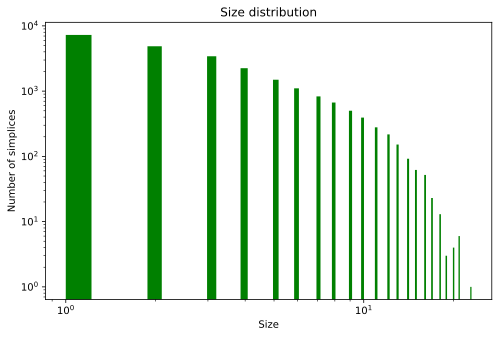

In [61]:
# create a new column that is the len of df['Simplices']
df['Size'] = df['Simplices'].apply(lambda x: len(x))

# plot size distribution
plt.figure(figsize=(8,5))
plt.hist(df['Size'], bins=100, color='g')
plt.xlabel('Size')
plt.ylabel('Number of simplices')
plt.yscale('log')
plt.xscale('log')
plt.title('Size distribution')
plt.show()